In [1]:
import matplotlib.pyplot as plt
from grav_lens.utils import load_tf_dataset

In [3]:
# el home debe apuntar a la carpeta que contiene la data
# personalmente la tengo en final/
dataset = load_tf_dataset(max_files=100, home='..')

for X, Y in dataset.take(1):  # Solo mostrar los primeros 5 elementos
    print("X:", X.shape)
    print("Y:", Y.shape)
# quedan cargados a memoria

Using data folder: ..\data\1
X: (3, 128, 128)
Y: (128, 128)


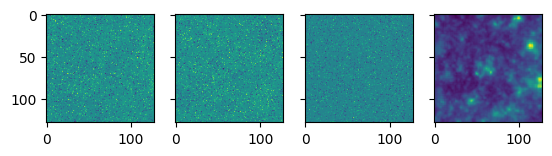

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True)
for X, Y in dataset.take(1):  # Solo mostrar los primeros 5 elementos
    for idx, channel in enumerate(X):
        ax[idx].imshow(channel)
    ax[-1].imshow(Y)

plt.show()

## estudiando la distribucion
Para estudiar la distribucion de los datos, en particular la distribucion de lo que corresponde a la materia oscura

In [16]:
darkm = Y.numpy()
darkm.flatten() # corresponde a la lista de valores

array([[-0.04337, -0.03793, -0.03574, ..., -0.03415, -0.0355 , -0.0374 ]],
      dtype=float16)

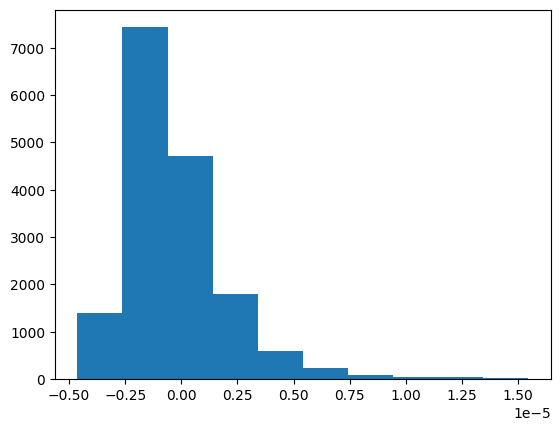

In [21]:
plt.hist(darkm.flatten())
plt.show()

## Encontrar los peaks
Utilizare `5 sigmas` rule

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label, center_of_mass
from scipy import stats

def get_stats(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return mean, std_dev

def get_peaks(data, mean, std_dev, sigmas = 5):
    threshold = mean + sigmas * std_dev  # 5 sigma threshold
    peaks = data > threshold
    labeled, num_features = label(peaks)
    peak_indices = center_of_mass(data, labeled, range(1, num_features + 1))
    return peak_indices


In [51]:
def plot_peaks(data, sigmas=5, ax1=None, ax2=None):
    if ax1 is None or ax2 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    mean, std_dev = get_stats(data)
    peak_idx = get_peaks(data, mean, std_dev, sigmas)

    # Plot the data with peaks highlighted on ax1
    im = ax1.imshow(data, origin='lower')
    ax1.set_title('Peaks above {} Sigma'.format(sigmas))
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    # Plot the peaks
    for peak in peak_idx:
        y, x = peak
        ax1.plot(x, y, 'rx', markersize=10, markeredgewidth=2)  # Cross marker

        # Draw confidence interval (e.g., 1 sigma circle)
        confidence_interval = plt.Circle((x, y), std_dev, color='r', fill=False, linestyle='--')
        ax1.add_patch(confidence_interval)
    
    # Add a colorbar
    plt.colorbar(im, ax=ax1, label='Density')

    # Plot the distribution of values on ax2
    ax2.hist(data.ravel(), bins=50, color='blue', alpha=0.7)
    ax2.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
    ax2.axvline(mean + sigmas * std_dev, color='green', linestyle='dashed', linewidth=1, label=f'{sigmas} Sigma')
    ax2.set_title('Distribution of Values')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    plt.tight_layout()
    plt.show()

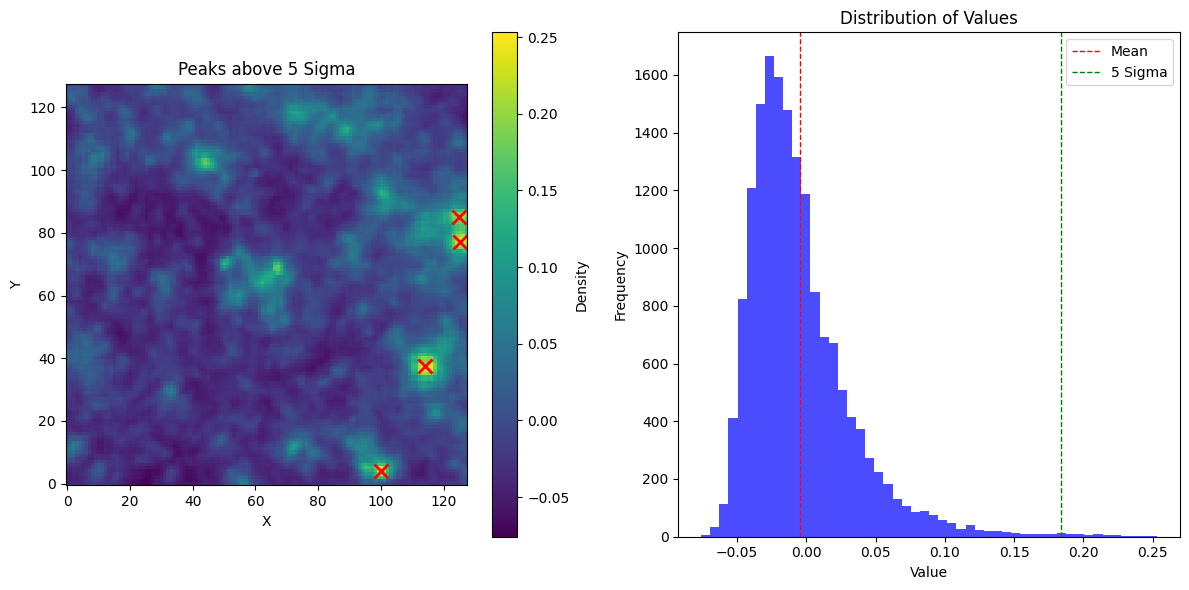

In [52]:
plot_peaks(data, sigmas=5)